# Predict Depression

* Model1: Tokenizer + Bidirectional LSTM
* Model2: TextVectorization + Bidirectional LSTM

In [1]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, TextVectorization, Flatten
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import plot_model

from wordcloud import WordCloud,STOPWORDS
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
df = pd.read_csv("depression_dataset_reddit_cleaned.csv")
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


## Exploratory Data Analysis

In [4]:
print(df.shape)
df.is_depression.value_counts(normalize=True)

(7731, 2)


0    0.504463
1    0.495537
Name: is_depression, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
nltk.download('punkt')   # for stemming
nltk.download('wordnet')  # for lemmatizer
nltk.download('omw-1.4') # for lemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Depression Tag Cloud

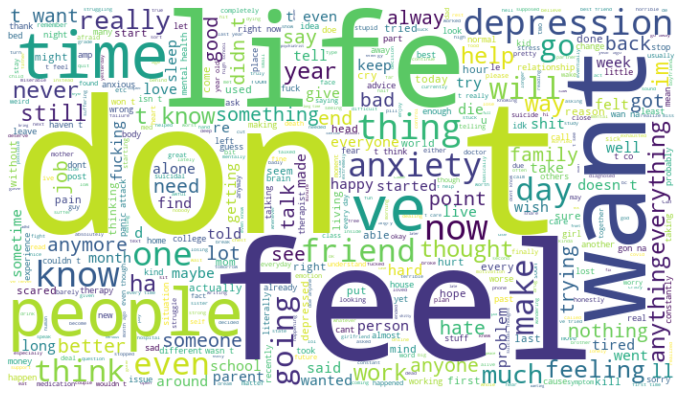

In [7]:
swords = ['wa','s','m']+list(STOPWORDS)

plt.figure(figsize=(12,10))
wc = WordCloud(max_words=500, width=700, height=400,background_color='white', 
               stopwords=swords).generate(" ".join(df[df.is_depression==1].clean_text))
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')

## Build Models
* Model1:  utilize Tokenizer (with text_to_sequence and pad_sequence) to map strings to integer representation.  
* Model2:  utilize Tensorflow's TextVectorization() to normalize, split and map strings to integers representation.  

### Model1 


### Data Preprocessing


  - convert to lower case
  - remove noncharacter 
  - remove stopwords
  - optional - apply lemmartization


In [8]:
def preprocess_text(text,islemma = False,rm_stopwords = False):
  txt = text.lower()
  txt = re.sub(r'[^a-zA-Z]',' ',txt)
  if rm_stopwords:
    txt = ' '.join([w for w in txt.split() if w not in stop_words])
  if islemma:
    lema = WordNetLemmatizer()
    txt = ' '.join([lema.lemmatize(w) for w in txt.split()])
  
  return txt

In [9]:
# df['proc_txt'] = df['clean_text'].apply(preprocess_text,islemma=True,rm_stopwords=True)
df['proc_txt'] = df['clean_text'].apply(preprocess_text)
df.head()

,clean_text,is_depression,proc_txt
0,we understand that most people who reply immed...,1,we understand that most people who reply immed...
1,welcome to r depression s check in post a plac...,1,welcome to r depression s check in post a plac...
2,anyone else instead of sleeping more when depr...,1,anyone else instead of sleeping more when depr...
3,i ve kind of stuffed around a lot in my life d...,1,i ve kind of stuffed around a lot in my life d...
4,sleep is my greatest and most comforting escap...,1,sleep is my greatest and most comforting escap...


In [10]:
MAX_FEATURE = 10000 
EMBED_DIM = 16
BATCH_SIZE = 200
EPOCH = 50
MAX_SEQ_LEN1 = 500
MAX_SEQ_LEN2 = 500

#### Split into Training and Testing Datasets

In [11]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df['proc_txt'].values,df['is_depression'].values,
                                                    test_size=0.2, random_state=1,
                                                    stratify=df['is_depression'].values,
                                                    shuffle=True)

#### Tokenization  

* use training dataset to build tokens 
* convert text to sequences using the tokens 

In [12]:
tkn1 = Tokenizer(num_words= MAX_FEATURE,oov_token="_OOV")
tkn1.fit_on_texts(X_train1)

X_train_seq1 = tkn1.texts_to_sequences(X_train1)
X_test_seq1 = tkn1.texts_to_sequences(X_test1)

# MAX_SEQ_LEN1 = np.max(list(map(lambda x: len(x), X_train_seq1)))  # 1845 - too large

#### Padding

In [13]:
from tensorflow.python.ops.gen_data_flow_ops import padding_fifo_queue
def apply_padding(input_data,max_length, padding_position='post',truncating_position='post'):
  return pad_sequences(input_data, maxlen=max_length, padding=padding_position, truncating=truncating_position)

In [14]:
X_train_pad1 = apply_padding(X_train_seq1,MAX_SEQ_LEN1)
X_test_pad1 = apply_padding(X_test_seq1,MAX_SEQ_LEN1)

In [15]:
def build_model1():
  model = Sequential()
  model.add(Embedding(input_dim=MAX_FEATURE+1,output_dim=EMBED_DIM,input_length=MAX_SEQ_LEN1))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dropout(0.2))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         tf.keras.metrics.AUC(name='AUC'),
                         keras.metrics.AUC(name='PRC', curve='PR')
                         ])
  return model

In [16]:
def fit_model(model,trainX,trainy):
  history = model.fit(trainX,trainy,
                    validation_split=0.2,
                    batch_size=BATCH_SIZE,epochs=EPOCH,
                    verbose=1,
                    callbacks=[
                            EarlyStopping(
                            monitor='val_accuracy',
                            patience=3,
                            mode = 'max',
                            restore_best_weights=True
                        )
                        
                    ]
                   )
  
  print(pd.DataFrame(model.history.history))
  return history

In [17]:
def plot_metrics(history):
  metrics = ['loss', 'PRC', 'AUC', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'AUC':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           160016    
                                                                 
 dropout (Dropout)           (None, 500, 16)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 500, 128)         41472     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 500, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

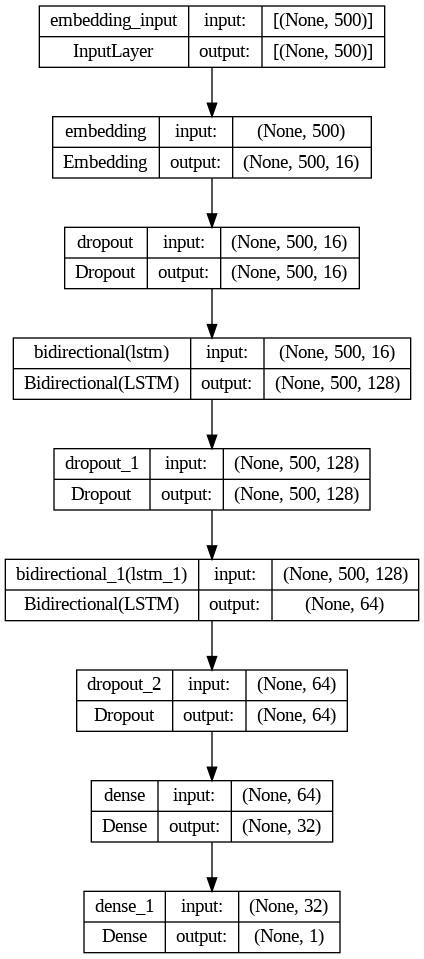

In [18]:
model1 = build_model1()
model1.summary()
plot_model(model1,show_shapes=True)

Epoch 1/50
25/25 [==============================] - 24s 345ms/step - loss: 0.5612 - accuracy: 0.7696 - AUC: 0.8476 - PRC: 0.8778 - val_loss: 0.3190 - val_accuracy: 0.8731 - val_AUC: 0.8992 - val_PRC: 0.9343
Epoch 2/50
25/25 [==============================] - 5s 206ms/step - loss: 0.3237 - accuracy: 0.8731 - AUC: 0.8976 - PRC: 0.9302 - val_loss: 0.2821 - val_accuracy: 0.8909 - val_AUC: 0.9155 - val_PRC: 0.9446
Epoch 3/50
25/25 [==============================] - 4s 176ms/step - loss: 0.2524 - accuracy: 0.9074 - AUC: 0.9376 - PRC: 0.9565 - val_loss: 0.2440 - val_accuracy: 0.9103 - val_AUC: 0.9539 - val_PRC: 0.9666
Epoch 4/50
25/25 [==============================] - 3s 129ms/step - loss: 0.1879 - accuracy: 0.9349 - AUC: 0.9677 - PRC: 0.9764 - val_loss: 0.1876 - val_accuracy: 0.9264 - val_AUC: 0.9817 - val_PRC: 0.9834
Epoch 5/50
25/25 [==============================] - 2s 97ms/step - loss: 0.1226 - accuracy: 0.9604 - AUC: 0.9856 - PRC: 0.9890 - val_loss: 0.1343 - val_accuracy: 0.9515 - val_

[0.08804198354482651,
 0.976729154586792,
 0.9925358891487122,
 0.9937710762023926]

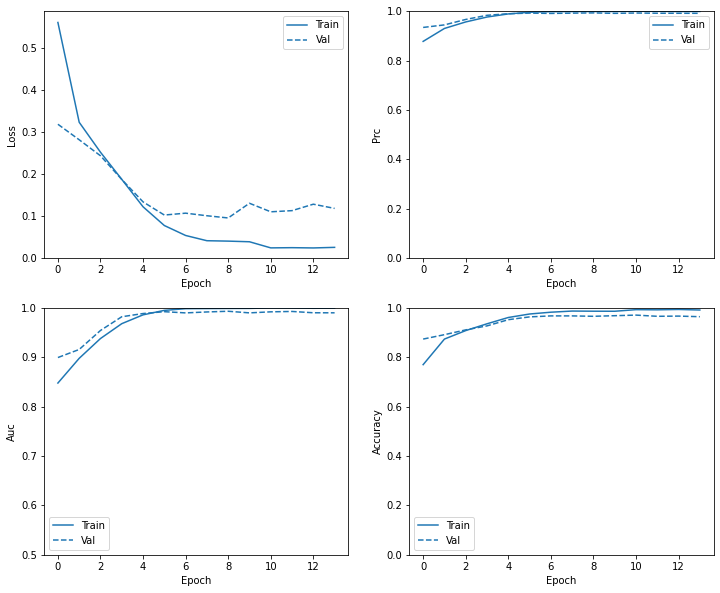

In [19]:
history1 = fit_model(model1,X_train_pad1,y_train1)
plot_metrics(history1)
results1 = model1.evaluate(X_test_pad1,y_test1,verbose=1)
results1

In [20]:
model1.save("model1.h5")

### Model2

#### Split into Training & Testing Datasets

In [21]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df['clean_text'].values,df['is_depression'].values,
                                                    test_size=0.2, random_state=1,
                                                    stratify=df['is_depression'].values,
                                                    shuffle=True)

#average word length
# MAX_SEQ_LEN2 =round(sum([len(r.split()) for r in X_train2])/len(X_train2))   # avg: 76

#### TextVectorization



In [22]:
text_vectorizer = TextVectorization(
                        standardize='lower_and_strip_punctuation',
                        max_tokens= MAX_FEATURE,
                        output_mode='int',
                        output_sequence_length=MAX_SEQ_LEN2
                        )

text_vectorizer.adapt(X_train2)
print(text_vectorizer.vocabulary_size())
print(len(text_vectorizer.get_vocabulary()))
text_vectorizer.get_vocabulary()[:10]

10000
10000


['', '[UNK]', 'i', 'to', 'and', 'a', 'the', 'my', 'it', 't']

In [23]:
#@title
def build_model2():
  model = Sequential()
  model.add(tf.keras.Input(shape=(1,), dtype=tf.string, name='text'))
  model.add(text_vectorizer)
  model.add(Embedding(input_dim=MAX_FEATURE+1,output_dim=EMBED_DIM))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(64,return_sequences=True)))
  model.add(Dropout(0.25))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dropout(0.2))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         tf.keras.metrics.AUC(name='AUC'),
                         keras.metrics.AUC(name='PRC', curve='PR')
                         ])
  return model

  


#### Model Summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 500, 16)           160016    
                                                                 
 dropout_3 (Dropout)         (None, 500, 16)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 500, 128)         41472     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 500, 128)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)              

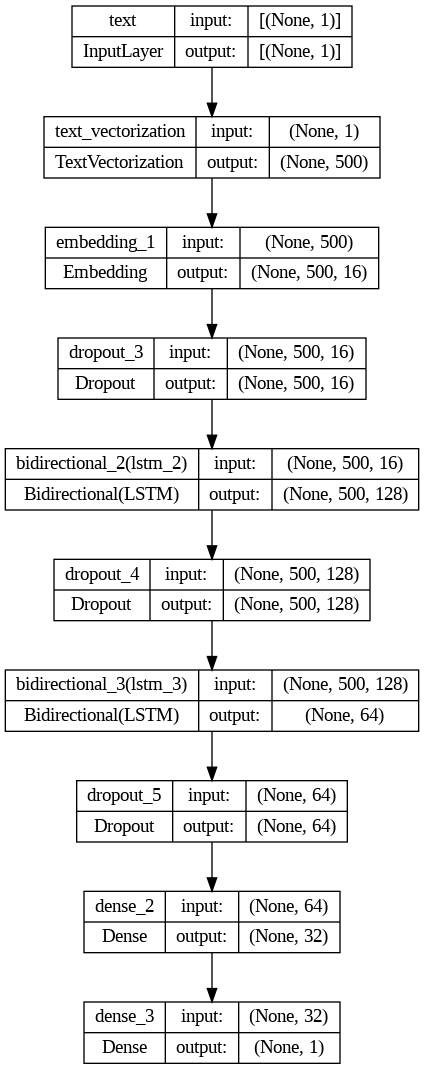

In [24]:
model2 = build_model2()
model2.summary()
plot_model(model2,show_shapes=True)

#### Model Performance

Epoch 1/50
25/25 [==============================] - 11s 189ms/step - loss: 0.5980 - accuracy: 0.6944 - AUC: 0.8073 - PRC: 0.8341 - val_loss: 0.3499 - val_accuracy: 0.8739 - val_AUC: 0.8996 - val_PRC: 0.9341
Epoch 2/50
25/25 [==============================] - 3s 114ms/step - loss: 0.3109 - accuracy: 0.8815 - AUC: 0.9030 - PRC: 0.9342 - val_loss: 0.2786 - val_accuracy: 0.8901 - val_AUC: 0.9170 - val_PRC: 0.9450
Epoch 3/50
25/25 [==============================] - 2s 99ms/step - loss: 0.2613 - accuracy: 0.9036 - AUC: 0.9299 - PRC: 0.9515 - val_loss: 0.2537 - val_accuracy: 0.9014 - val_AUC: 0.9625 - val_PRC: 0.9720
Epoch 4/50
25/25 [==============================] - 3s 101ms/step - loss: 0.1775 - accuracy: 0.9398 - AUC: 0.9725 - PRC: 0.9798 - val_loss: 0.1834 - val_accuracy: 0.9272 - val_AUC: 0.9872 - val_PRC: 0.9891
Epoch 5/50
25/25 [==============================] - 2s 98ms/step - loss: 0.3504 - accuracy: 0.8961 - AUC: 0.9388 - PRC: 0.9046 - val_loss: 0.2366 - val_accuracy: 0.9038 - val_A

[0.09462317079305649,
 0.9734970927238464,
 0.9931183457374573,
 0.9945681691169739]

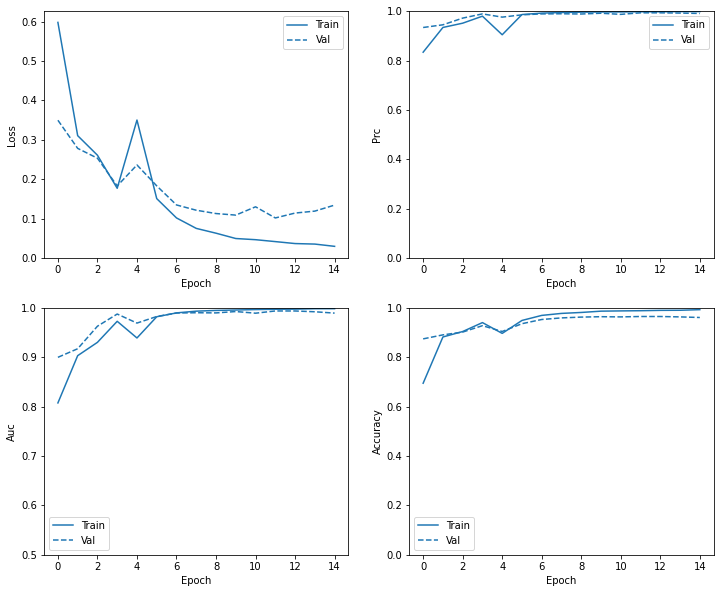

In [25]:
history2 = fit_model(model2,X_train2,y_train2)
plot_metrics(history2)
results2 = model2.evaluate(X_test2,y_test2,verbose=2)
results2

## Performance Comparison
* Evaluation Metrics
  - Confustion Matrix
  - Classification Reports
  - Precision Recall Curve

In [26]:
def test_eval(clf_model, testX, testy):
    # Test set prediction
    y_pred=clf_model.predict(testX)
    y_predict = []
    for p in y_pred:
        if p > 0.5:
            y_predict.append(1)
        else:
            y_predict.append(0)
    print('Confusion Matrix')
    print('='*60)
    cm = confusion_matrix(testy,y_predict)
    print(cm,"\n")
    print('Classification Report')
    print('='*60)
    cr = classification_report(testy,y_predict)
    print(cr,"\n")
    
    return cm,cr,y_predict

def plot_cmatrix(cmatrix, name):
    fig = px.imshow(cmatrix,color_continuous_scale=[[0.0, 'peachpuff'], 
                                          [0.5, 'lime'], 
                                          [1.0, 'green']])

    fig.update_layout(
        title = 'Confusion Matrix ('+ name + ')', title_x=0.5,
        xaxis_title="Predicted Label", yaxis_title="Actual Label", 
        height=400,
        width=400,
        xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1),
        yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1)
    )
    for i in range(len(cmatrix)):
        for j in range(len(cmatrix[0])):
            fig.add_annotation(
                x=j,
                y=i,
                text=str(cmatrix[i,j]),
                showarrow=False,
                font_size=9, font_color='black'
            )

    fig.show()

cm1,cr1,_  = test_eval(model1,X_test_pad1,y_test1)
cm2,cr2,_  = test_eval(model2,X_test2,y_test2)

plot_cmatrix(cm1, name='Model1')
print()
plot_cmatrix(cm2, name='Model2')

49/49 [==============================] - 3s 30ms/step
Confusion Matrix
[[769  11]
 [ 25 742]] 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       780
           1       0.99      0.97      0.98       767

    accuracy                           0.98      1547
   macro avg       0.98      0.98      0.98      1547
weighted avg       0.98      0.98      0.98      1547
 

49/49 [==============================] - 4s 32ms/step
Confusion Matrix
[[765  15]
 [ 26 741]] 

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       780
           1       0.98      0.97      0.97       767

    accuracy                           0.97      1547
   macro avg       0.97      0.97      0.97      1547
weighted avg       0.97      0.97      0.97      1547
 



In [27]:
precision1, recall1, _ = precision_recall_curve(y_test1, model1.predict(X_test_pad1))
precision2, recall2, _ = precision_recall_curve(y_test2, model2.predict(X_test2))

fig = go.Figure()
fig.add_trace(go.Scatter(x=recall1,y=precision1,mode='lines',name='Model1'))
fig.add_trace(go.Scatter(x=recall2,y=precision2,mode='lines',name='Model2'))

fig.update_layout(title='Precision-Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision', title_x = 0.5,
                   width = 800, height=450,
                 )
fig.show()

49/49 [==============================] - 1s 29ms/step


In [28]:
new_data = ["I don't think anyone really understands how tiring it is to act okay and always be the 'strong' one when in reality you're close to the edge.",
            "I feel mentally exhaused and struggle to get through everyday life.",
            "I'm super excited and looking forward to travelling next week.",
            "got friends prank call yoooooo yall got numbers boys prank call us",
            "I had suicidal thoughts for weeks and tried therapy but nothing seems to be working",
            ]

model2.predict(new_data)


1/1 [==============================] - 0s 55ms/step


array([[0.9959551 ],
       [0.9579207 ],
       [0.00767677],
       [0.01008139],
       [0.989943  ]], dtype=float32)

In [29]:
proc_new_data = apply_padding(tkn1.texts_to_sequences(new_data), MAX_SEQ_LEN1)
model1.predict(proc_new_data)

1/1 [==============================] - 0s 46ms/step


array([[0.9807304 ],
       [0.99393624],
       [0.00121173],
       [0.00177051],
       [0.96562797]], dtype=float32)

#Summary 
Detecting depression using Bidirectional LSTM is implemented in two ways as follows:
* Tokenizer: The first approach requires new data to transform it into integer sequence representation before feeding it to the prediction model.  
* TextVectorization: The second approach is an inference end-to-end model where the new data can be feed into the model as string representation (i.e., no need to transform the new input data to integer representation).   


In [30]:
# model2.save("model2")